In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from tensorflow.python import debug as tf_debug
from datetime import datetime
import _pickle as cPickle
import os
import time
import shutil
from pathlib import Path
#%load_ext autotime
%matplotlib inline

/home/gabriel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/gabriel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
flags = tf.app.flags
FLAGS = flags.FLAGS
#0.0008
flags.DEFINE_float('learning_rate', 0.0008, 'Initial learning rate.')
flags.DEFINE_integer('max_steps', 50000, 'Number of iteration to train.')
flags.DEFINE_integer('number_layers', 3, 'Number of layers in each network')
flags.DEFINE_integer('layer_sizes', 256, 'Number of units in hidden layer.')
flags.DEFINE_integer('batch_size', 100, 'Batch size.')
flags.DEFINE_integer('dim_env', 2, 'dimension of the environment')
flags.DEFINE_integer('number_goal_types', 3, 'number of different goal types')
flags.DEFINE_integer('color_size', 3, 'number of components of the color: RGB as usual')
flags.DEFINE_integer("output_size", 256, "number of units in the output layer")
flags.DEFINE_float("keep_prob", 0.9, "Dropouts rate of keeping")
flags.DEFINE_boolean("xav_init", False,"Distribution of initialization: False for normal, True for uniform" )
flags.DEFINE_integer("number_agents", 2, "Number of agents in the environment")
flags.DEFINE_integer("number_landmarks", 3, "Number of landmarks in the environment")
flags.DEFINE_integer("vocabulary_size", 20, "Size of the vocabulary")
flags.DEFINE_integer("mem_size", 32, "Size of the communication network's memory")
flags.DEFINE_integer("last_mem_size", 32, "Size of the last network's memory")
flags.DEFINE_float("gumbel_temperature", 1, "Temperature use for the gumbel softmax trick")
flags.DEFINE_float("sddev_phys_sampling", 0.0001, "Standard deviation used to sample the velocity and gaze output")
flags.DEFINE_float("delta_t", 0.5, "delta of time between timesteps")
flags.DEFINE_float("damping_coef", 0.5, "damping coefficient for the new velocity computation")
flags.DEFINE_float("stddev_memory", 0.0001, "standard deviation of the gaussian used to update memories")
flags.DEFINE_integer("bound", 5, "Bounds of generation of initial positions, centered in 0.")#5 usually
flags.DEFINE_integer("time_horizon", 50, "Number of timestep before the end of the experiment.")
flags.DEFINE_integer("print_frequency", 500, "Frequency at which we print the reward, in number of steps.")#1
flags.DEFINE_boolean("learning_rate_decay", True, "Wether to use a piecewise learning rate decay or no decay at all")
flags.DEFINE_integer("tensorboard_freq", 500, "Frequency at which we save the statistics in tensorflow")
flags.DEFINE_float("alpha_dirichlet", 0.1, "Probability of seeing an out of vocabulary word")

In [69]:
tf.reset_default_graph()

### A faire:

- Checker que le softmax pooling est correct

- Checker que le gumbel trick est okay, notamment sur les début et longueur de slicing

- Checker que le sampling physique est okay, notamment sur les début et longueur de slicing

- Checker que le calcul du nouvel état est correct, notamment sur les débuts et longueur de slicing et concaténation

- Ajouter le calcul des forces dans le calcul du nouvel état

- Vérifier que le shuffling est correct

- Vérifier que le calcul du reward est correct

- Vérifier que la backprop considère bien les variables broadcastées comme les mêmes.

- Vérifier que le tenseur states est bien dans cet ordre sur le second axe: position, velocité, gaze, couleurs

- RELIER LES LANDMARKS AUX POSITIONS DES GOALS, SINON CA N A PAS DE SENS !!!

- Checker que les goals types sont bien distribués: une unique coordonnée doit être 1, les autres 0, et ce pour chaque agent.


## Utils

In [70]:
def memory():
    import os
    import psutil
    pid = os.getpid()
    py = psutil.Process(pid)
    memoryUse = py.memory_info()[0]/2.**30  # memory use in GB...I think
    print('memory use:', memoryUse)




def plot_trajectory(coordinates, target_point, middle_point):
    x = coordinates[1:-1, 0]
    y = coordinates[1:-1, 1]
    
    x_start = coordinates[0, 0]
    y_start = coordinates[0, 1]
    
    x_final = coordinates[-1, 0]
    y_final = coordinates[-1, 1]
    
    x_target, y_target = target_point
    x_middle, y_middle = middle_point
    
    plt.plot(x,y, "o")
    plt.plot(x_start, y_start, 'ro')
    plt.plot(x_target, y_target, 'go')
    plt.plot(x_final, y_final, 'yo')
    plt.plot(x_middle, y_middle, 'mo')
    axes = plt.gca()
    axes.set_xlim([-FLAGS.bound, FLAGS.bound])
    axes.set_ylim([-FLAGS.bound, FLAGS.bound])
    plt.show()


def python_shuffle(positions, shuffle_indexes):
    shuffled_array = np.stack(
    [positions[shuffle_indexes[: , 0, i], :, i] for i in range(FLAGS.batch_size)], axis = 2)
    return shuffled_array
    
    
def delete_history_files():
    if os.path.isfile("env_history.pkl"):
        os.remove("env_history.pkl")
        
    if os.path.isfile("arrays_history.pkl"):
        os.remove("arrays_history.pkl")
        
    if Path("Summary").is_dir():
        shutil.rmtree("Summary")


def print_stat_vocabulary(utterances_array, l):
    x = np.argmax(utterances_array, axis = 2)
    r = []
    for i in range(FLAGS.batch_size):
        r.append(len(np.unique(x[:, :, i])))
    
    if l%FLAGS.print_frequency == 0:
        print("-- Stats word count:")
        print("---- Mean number of word activated: " + str(np.mean(r)))
        print("---- Median number of word activated: " + str(np.median(r)))
        print("---- Total number of word activated: " + str(len(np.unique(x))))
        
    return np.mean(r)
    
        
def dirichlet_log_lik_end(utterances_array):
    #Note: we don't take minus the log-likelihood as we minimize minus the entire reward then !
    by_symbol = tf.reduce_sum(utterances_array, axis =[0, 1, 3])
    total_nb_uttered = FLAGS.number_agents*FLAGS.time_horizon*FLAGS.batch_size
    ratio = by_symbol/(FLAGS.alpha_dirichlet + total_nb_uttered - 1)
    #ratio = by_symbol/(FLAGS.alpha_dirichlet + tf.reduce_sum(utterances_array) - 1)
    terms = tf.gather(tf.log(ratio)*by_symbol, tf.where(tf.not_equal(by_symbol, 0)))
    log_likelihood = tf.reduce_sum(terms)
    log_likelihood = tf.Print(log_likelihood, [log_likelihood])
    return log_likelihood
    
    
# Param: x, stacking of the output of fully connected physical network for each agent. Shape = (256, batch_size, nb_agents)
# return: pooling of input features.
def softmax_pooling(x):
    # pooling function. Softmax pooling is a compromise between max pooling and average pooling
    coefs = tf.nn.softmax(x, dim = 0)
    softmax_pool = tf.reduce_sum(tf.multiply(coefs, x), axis = 0)
    return softmax_pool


def activation_function(x):
    return tf.nn.elu(x)


def gumbel_max_trick(x, hard = True):
    # Application of gumbel-softmax trick
    # Input: output of the last network 
    u = -tf.log(-tf.log(tf.random_uniform(shape = [FLAGS.number_agents, FLAGS.vocabulary_size, FLAGS.batch_size],
                                          dtype=tf.float32)))
    utterance_output = tf.slice(x, [0, 2*FLAGS.dim_env, 0], [FLAGS.number_agents, FLAGS.vocabulary_size, FLAGS.batch_size])
    gumbel = tf.exp((utterance_output + u)/FLAGS.gumbel_temperature)
    denoms = tf.reshape(tf.reduce_sum(gumbel, axis = 1), [FLAGS.number_agents, 1, FLAGS.batch_size])
    utterance = gumbel/denoms
    if hard:
        idx_utt = tf.argmax(utterance, axis = 1)
        utt_hard = tf.transpose(tf.one_hot(idx_utt, depth = FLAGS.vocabulary_size), [0, 2, 1])
        utterance = tf.stop_gradient(utt_hard - utterance) + utterance
        
    return utterance 


def sample_phys(x):
    #Input: output of the last network.
    #Output: sampled values for new velocity and gaze
    u = tf.random_normal(shape = [FLAGS.number_agents, 2*FLAGS.dim_env, FLAGS.batch_size],dtype=tf.float32,
                         stddev = FLAGS.sddev_phys_sampling)
    o = tf.add(tf.slice(x, [0, 0, 0], [FLAGS.number_agents, 2*FLAGS.dim_env, FLAGS.batch_size]), u)
    sample_move = tf.slice(o, [0, 0, 0], [FLAGS.number_agents, FLAGS.dim_env, FLAGS.batch_size])
    sample_gaze  = tf.slice(o, [0, FLAGS.dim_env, 0], [FLAGS.number_agents, FLAGS.dim_env, FLAGS.batch_size])
    return sample_move, sample_gaze


def compute_new_states(old_states, new_velocities, new_delta_gazes, new_utterances):
    #Computes the new states according to the equations of the papers.
    # Input: the old states of shape [number agents + nb_landmarks, 3*env dim + color size, batch size] because color is in state
    # and of shape [number_agents, 2*env_dim, batch size]
    # Adding the outputs of landmark, which are all zeros.
    #new_velocities = tf.concat([new_velocities, tf.zeros([FLAGS.number_landmarks, FLAGS.dim_env, FLAGS.batch_size])],
    #                                       axis = 0)

    #new_delta_gazes = tf.concat([new_delta_gazes, tf.zeros([FLAGS.number_landmarks, FLAGS.dim_env, FLAGS.batch_size])],
    #                                       axis = 0)
    
    #old_velocity = tf.slice(old_states, [0, FLAGS.dim_env, 0], 
    #                        [FLAGS.number_agents + FLAGS.number_landmarks, FLAGS.dim_env, FLAGS.batch_size])
    
    #old_gazes = tf.slice(old_states, [0, 2*FLAGS.dim_env, 0], 
    #                        [FLAGS.number_agents + FLAGS.number_landmarks, FLAGS.dim_env, FLAGS.batch_size])
    
    #new_pos = tf.slice(old_states, [0, 0, 0], 
    #                   [FLAGS.number_agents + FLAGS.number_landmarks, FLAGS.dim_env, FLAGS.batch_size]) + old_velocity*FLAGS.delta_t
    
    #new_gazes = old_gazes + new_delta_gazes*FLAGS.delta_t
    
    #new_velocity = (1 - FLAGS.damping_coef)*old_velocity + new_velocities*FLAGS.delta_t
    
    old_velocity = tf.slice(old_states, [0, FLAGS.dim_env, 0], 
                            [FLAGS.number_agents, FLAGS.dim_env, FLAGS.batch_size])
    
    old_gazes = tf.slice(old_states, [0, 2*FLAGS.dim_env, 0], 
                            [FLAGS.number_agents , FLAGS.dim_env, FLAGS.batch_size])
    
    new_pos_agents = tf.slice(old_states, [0, 0, 0], 
                       [FLAGS.number_agents, FLAGS.dim_env, FLAGS.batch_size]) + old_velocity*FLAGS.delta_t
    
    new_pos_landmarks = tf.slice(old_states, [FLAGS.number_agents, 0, 0], 
                       [FLAGS.number_landmarks, FLAGS.dim_env, FLAGS.batch_size])
    new_pos = tf.concat([new_pos_agents, new_pos_landmarks], axis = 0)
    
    new_gazes_agents = old_gazes + new_delta_gazes*FLAGS.delta_t
    new_gazes_landmarks = tf.zeros([FLAGS.number_landmarks, FLAGS.dim_env, FLAGS.batch_size])
    new_gazes = tf.concat([new_gazes_agents, new_gazes_landmarks], axis = 0)
    
    new_velocity_agents = (1 - FLAGS.damping_coef)*old_velocity + new_velocities*FLAGS.delta_t
    new_velocity_landmarks = tf.zeros([FLAGS.number_landmarks, FLAGS.dim_env, FLAGS.batch_size])
    new_velocity = tf.concat([new_velocity_agents, new_velocity_landmarks], axis = 0)
    
    colors = tf.slice(old_states, [0, 3*FLAGS.dim_env, 0], [FLAGS.number_agents + FLAGS.number_landmarks, 
                                                            FLAGS.color_size, FLAGS.batch_size])
    new_states = tf.concat([new_pos, new_velocity, new_gazes, colors], axis = 1)

    return new_states, new_pos, new_gazes



def compute_new_memories(old_mem_com, old_mem_last, delta_mem_com, delta_mem_last):
    new_memory_com = tf.tanh((2/3)*(old_mem_com + delta_mem_com + tf.random_normal([FLAGS.number_agents, FLAGS.mem_size,
                                                                             FLAGS.batch_size], FLAGS.stddev_memory)))
    new_memory_last = tf.tanh((2/3)*(old_mem_last + delta_mem_last + tf.random_normal([FLAGS.number_agents, FLAGS.mem_size,
                                                                             FLAGS.batch_size], FLAGS.stddev_memory)))
    
    return new_memory_com,new_memory_last



def shuffle(x, name_targets, colors = False):
    slices_second_dim = []
    ones = tf.ones([FLAGS.number_agents, 1, FLAGS.batch_size], tf.int32)
    batch_num = tf.tile(tf.reshape(tf.range(0, FLAGS.batch_size, dtype = tf.int32), [1, 1, FLAGS.batch_size]), [FLAGS.number_agents,
                                                                                                               1, 1])
    if not colors:
        for i in range(FLAGS.dim_env):
            slices_second_dim.append(tf.reshape(tf.concat([name_targets, ones*i, batch_num], axis = 1), 
                                            [FLAGS.number_agents, 1, 3, FLAGS.batch_size]))
    else:
        for i in range(FLAGS.color_size):
            slices_second_dim.append(tf.reshape(tf.concat([name_targets, ones*i, batch_num], axis = 1), 
                                            [FLAGS.number_agents, 1, 3, FLAGS.batch_size]))
            
    gathering_tensor = tf.transpose(tf.concat(slices_second_dim, axis = 1), perm = [0, 1, 3, 2])
    shuffled_x = tf.gather_nd(x, gathering_tensor)
    
    return shuffled_x
    
    
def compute_reward(positions, gazes, outputs, utterances, name_targets, goals_loc, goals_types):
    shuffled_positions = shuffle(positions, name_targets)
    shuffled_gazes = shuffle(gazes, name_targets)

    pos_distances = tf.reshape(tf.reduce_sum(tf.square((shuffled_positions - goals_loc)), axis = 1), [FLAGS.number_agents, 1, 
                                                                                                     FLAGS.batch_size])

    gaze_distances = tf.reshape(tf.reduce_sum(tf.square((shuffled_gazes - goals_loc)), axis = 1), [FLAGS.number_agents, 1,
                                                                                                     FLAGS.batch_size])
    zeros = tf.zeros([FLAGS.number_agents, 1, FLAGS.batch_size])
    x = tf.concat([pos_distances, gaze_distances, zeros], axis = 1)

    dists_goal = -tf.reduce_sum(tf.multiply(x, goals_types), axis = 1)
    
    utterances_term = -tf.reduce_sum(tf.square(utterances), axis = 1)
    output_term = -tf.reduce_sum(tf.square(outputs), axis = 1)
    
    reward_by_batch = tf.reshape(tf.reduce_sum(dists_goal + utterances_term + output_term, axis = 0), [FLAGS.batch_size, 1])

    return reward_by_batch



def compute_goal_dist(states, goal_location, goal_type):
    dist_positions = np.reshape(np.sqrt(np.sum((states[0:FLAGS.number_agents, 0:2, :] - goal_location)**2, axis = 1)), [FLAGS.number_agents, 1, FLAGS.batch_size])
    dist_gazes = np.reshape(np.sqrt(np.sum((states[0:FLAGS.number_agents, 4:6, :] - goal_location)**2, axis = 1)), [FLAGS.number_agents, 1, FLAGS.batch_size])
    v = np.concatenate([dist_positions, dist_gazes, np.zeros((FLAGS.number_agents, 1, FLAGS.batch_size))], axis = 1)
    goal_distances = np.sum(np.multiply(v, goal_type), axis = 1)
    
    return goal_distances


def print_stats_agent(states, goal_location, goal_type, targets):
    #Only considering non "do nothing goals"
    shuffled_states = python_shuffle(states, targets)
    goal_distances = compute_goal_dist(shuffled_states, goal_location, goal_type)
    
    for i in range(FLAGS.number_agents):
        distances_agents = goal_distances[i, :]
        goal_wo_zeros = distances_agents[distances_agents != 0]
        mean = np.mean(goal_wo_zeros)
        median = np.median(goal_wo_zeros)
        third_quart = np.percentile(goal_wo_zeros, 75)
        nine_pct = np.percentile(goal_wo_zeros, 90)
        max_dist = np.max(distances_agents)
        argmax = np.argmax(distances_agents)
        print("--- Agent " + str(i))
        print("------ Mean distance " + str(mean))
        print("------ Median distance " + str(median))
        print("------ Third quartile " + str(third_quart))
        print("------ Ninetieth percentile " + str(nine_pct))
        print("------ max distance " + str(max_dist))
        print("------ argmax distance " + str(argmax))

## Definition of the physical network

In [71]:
class PhysicalNet: 
    
    def __init__(self):
        self.input_size = 3*FLAGS.dim_env + FLAGS.color_size
        
        self.Weights = []
        self.Biases = []
        
        self.init_weights()
        self.init_biases()
        
    def init_weights(self):
        #Initialization of the weights of all the networks' layers
        #Weights are 3 dimensional arrays: [number of agents, number of units, number of inputs]
        #This shape enables us to handle all the agents/landmarks states at once, instead of dealing with list of agents' states
        with tf.variable_scope("phys_variable") as scope:
            for i in range(FLAGS.number_layers):
                if i == 0:
                    W = tf.tile(tf.get_variable("weight_" + str(i), shape=[1, FLAGS.layer_sizes, self.input_size],
                                        initializer=tf.orthogonal_initializer()),
                                [FLAGS.number_agents + FLAGS.number_landmarks, 1, 1])
                    tf.summary.histogram('phys_net_weight_'+ str(i), W)
                elif i != (FLAGS.number_layers - 1):
                    W = tf.tile(tf.get_variable("weight_" + str(i), shape=[1, FLAGS.layer_sizes, FLAGS.layer_sizes],
                                        initializer=tf.orthogonal_initializer()),
                                [FLAGS.number_agents + FLAGS.number_landmarks, 1, 1])
                    tf.summary.histogram('phys_net_weight_'+ str(i), W)
                else:
                    W = tf.tile(tf.get_variable("weight_" + str(i), shape=[1, FLAGS.output_size, FLAGS.layer_sizes],
                                        initializer=tf.orthogonal_initializer()), 
                                [FLAGS.number_agents + FLAGS.number_landmarks, 1, 1])
                    tf.summary.histogram('phys_net_weight_'+ str(i), W)

                self.Weights.append(W)
            
    def init_biases(self):
        #Initialization of the weights of all the networks' biases.
        # Same remark as the weights concerning the shapes of the biases.
        with tf.variable_scope("phys_variable") as scope:
            for i in range(FLAGS.number_layers):
                if i < (FLAGS.number_layers - 1):
                    B = tf.tile(tf.get_variable("bias_" + str(i), shape=[1, FLAGS.layer_sizes, 1],
                                            initializer=tf.orthogonal_initializer()),
                                [FLAGS.number_agents + FLAGS.number_landmarks, 1, 1])
                    tf.summary.histogram('phys_net_bias_'+ str(i), B)
                else:
                    B = tf.tile(tf.get_variable("bias_" + str(i), shape=[1, FLAGS.output_size, 1],
                                            initializer=tf.orthogonal_initializer()),
                                [FLAGS.number_agents + FLAGS.number_landmarks, 1, 1])
                    
                self.Biases.append(B)
            
            
    def compute_output(self, x): 
        # Compute a forward pass through the network
        # Input: a tensor of shape [number of agents, size of input, batch _size]
        # Output: a tensor of shape [number of agents, output_size, batch_size]
            for i in range(FLAGS.number_layers):
                W = self.Weights[i]
                b = self.Biases[i]
                if i != (FLAGS.number_layers - 1):
                    x = tf.nn.dropout(activation_function(tf.matmul(W, x) + b), keep_prob = FLAGS.keep_prob)
                else:
                    x = activation_function(tf.matmul(W, x) + b)
            
            return x

## Definition of the communication network

In [72]:
class CommunicationNet: 
    
    def __init__(self):    
        self.Weights = []
        self.Biases = []
        self.Weight_read_mem = tf.tile(tf.get_variable("com_memory_read_weight", shape = [1, FLAGS.output_size, FLAGS.mem_size],
                                               initializer=tf.orthogonal_initializer()),
                                               [FLAGS.number_agents, 1, 1])
        
        self.init_weights()    
        self.init_biases()
        self.def_delta_mem()
        
        
    def init_weights(self):
        #Initialization of the weights of all the networks' layers
        #Weights are 3 dimensional arrays: [number of agents, number of units, vocabulary size]
        #This shape enables us to handle all the agents utterances at once, instead of dealing with list of agents' states        
        with tf.variable_scope("com_variable") as scope:
            for i in range(FLAGS.number_layers):
                if i == 0:
                    W = tf.tile(tf.get_variable("com_net_weight_" + str(i), shape=[1, FLAGS.layer_sizes, FLAGS.vocabulary_size],
                                        initializer=tf.orthogonal_initializer()),
                                        [FLAGS.number_agents, 1, 1])
                    tf.summary.histogram('com_net_weight_'+ str(i), W)
                elif i != (FLAGS.number_layers - 1):
                    W = tf.tile(tf.get_variable("com_net_weight_" + str(i), shape=[1, FLAGS.layer_sizes, FLAGS.layer_sizes],
                                        initializer=tf.orthogonal_initializer()), 
                                        [FLAGS.number_agents, 1, 1])
                    tf.summary.histogram('com_net_weight_'+ str(i), W)
                else:
                    W = tf.tile(tf.get_variable("com_net_weight_" + str(i), shape=[1, FLAGS.output_size, FLAGS.layer_sizes],
                                        initializer=tf.orthogonal_initializer()),
                                        [FLAGS.number_agents, 1, 1])

                    tf.summary.histogram('com_net_weight_'+ str(i), W)

                self.Weights.append(W)
       
    
    def init_biases(self):
        #Initialization of the weights of all the networks' biases.
        # Same remark as the weights concerning the shapes of the biases.
        with tf.variable_scope("com_variable") as scope:
            for i in range(FLAGS.number_layers):
                if i < (FLAGS.number_layers - 1):
                    B = tf.tile(tf.get_variable("com_net_bias_" + str(i), shape = [1, FLAGS.layer_sizes, 1], 
                                   initializer = tf.orthogonal_initializer()), 
                                    [FLAGS.number_agents, 1, 1])
                    tf.summary.histogram('com_net_bias_'+ str(i), B)
                else:
                    B = tf.tile(tf.get_variable("com_net_bias_" + str(i), shape = [1, FLAGS.output_size, 1], 
                                   initializer = tf.orthogonal_initializer()), 
                                    [FLAGS.number_agents, 1, 1])  
                    
                self.Biases.append(B)
       
    
    def def_delta_mem(self):
        # Initialization of the weights and biases writing in the memory.
        # Their shape are of the form [number of agents, memory_size, output size] and [number of agents, output size, 1]
        # So that we can handle the memories of all agents at onces instead of dealing with list of memories.
        self.W_mem = tf.tile(tf.get_variable("weight_mem_com" , shape=[1, FLAGS.mem_size,FLAGS.output_size],
                            initializer=tf.orthogonal_initializer()), 
                             [FLAGS.number_agents, 1, 1])
        self.b_mem = tf.tile(tf.get_variable("bias_mem_com", shape = [1, FLAGS.mem_size, 1],
                            initializer=tf.orthogonal_initializer()),
                             [FLAGS.number_agents, 1, 1])

        
    def compute_output(self, x, memory):
        for i in range(FLAGS.number_layers):
            W = self.Weights[i]
            b = self.Biases[i]
            if i != (FLAGS.number_layers - 1):
                x = tf.nn.dropout(activation_function(tf.matmul(W, x) + b), keep_prob = FLAGS.keep_prob)
            else:
                x = activation_function(tf.matmul(W, x) + tf.matmul(self.Weight_read_mem, memory) + b)
                
            
        delta_mem = activation_function(tf.add(tf.matmul(self.W_mem, x),self.b_mem))
        return x, delta_mem

## Definition of the last network

In [73]:
class LastNet: 
    
    def __init__(self):
        self.input_size = 2*FLAGS.output_size + FLAGS.color_size + FLAGS.number_goal_types + FLAGS.dim_env
        self.output_size = 2*FLAGS.dim_env + FLAGS.vocabulary_size
        self.Weights = []
        self.Biases = []
        self.Weight_read_mem = tf.tile(tf.get_variable("reading_last_mem_weight", shape = [1, self.output_size, FLAGS.last_mem_size],
                                              initializer=tf.orthogonal_initializer()),
                                               [FLAGS.number_agents, 1, 1])
        
        self.init_weights()    
        self.init_biases()
        self.def_delta_mem()
        
        
    def init_weights(self):
        with tf.variable_scope("last_variable") as scope:
            for i in range(FLAGS.number_layers):
                if i == 0:
                    W = tf.tile(tf.get_variable("last_net_weight_" + str(i), shape=[1, FLAGS.layer_sizes, self.input_size],
                                        initializer=tf.orthogonal_initializer()), 
                                [FLAGS.number_agents, 1, 1])
                    tf.summary.histogram('last_net_weight_'+ str(i), W)
                elif i != (FLAGS.number_layers - 1):
                    W = tf.tile(tf.get_variable("last_net_weight_" + str(i), shape=[1, FLAGS.layer_sizes, FLAGS.layer_sizes],
                                        initializer=tf.orthogonal_initializer()),
                                [FLAGS.number_agents, 1, 1])
                    tf.summary.histogram('last_net_weight_'+ str(i), W)
                else:
                    W = tf.tile(tf.get_variable("last_net_weight_" + str(i), shape=[1, self.output_size, FLAGS.layer_sizes],
                                        initializer=tf.orthogonal_initializer()),
                                [FLAGS.number_agents, 1, 1])
                    tf.summary.histogram('last_net_weight_'+ str(i), W)

                self.Weights.append(W)
            
    def init_biases(self):
        with tf.variable_scope("last_variable") as scope:
            for i in range(FLAGS.number_layers):
                if i != (FLAGS.number_layers - 1):
                    B = tf.tile(tf.get_variable("last_net_bias_" + str(i), shape = [1, FLAGS.layer_sizes, 1], 
                                        initializer=tf.orthogonal_initializer()),
                                [FLAGS.number_agents, 1, 1])
                    tf.summary.histogram('last_net_bias_'+ str(i), B)
                else:
                    B = tf.tile(tf.get_variable("last_net_bias_" + str(i), shape = [1, self.output_size, 1], 
                                        initializer=tf.orthogonal_initializer()),
                                [FLAGS.number_agents, 1, 1])
                    tf.summary.histogram('last_net_bias_'+ str(i), B)

                self.Biases.append(B)

        
    def def_delta_mem(self):
        self.W_mem = tf.tile(tf.get_variable("weight_mem_last", shape=[1, FLAGS.last_mem_size ,self.output_size],
                                initializer=tf.orthogonal_initializer()),
                                 [FLAGS.number_agents, 1, 1])
        self.b_mem = tf.tile(tf.get_variable("bias_mem_last" ,shape = [1, FLAGS.last_mem_size, 1], 
                                    initializer=tf.orthogonal_initializer()),
                                  [FLAGS.number_agents, 1, 1])
        
    def compute_output(self, x, memory):
        for i in range(FLAGS.number_layers):
            W = self.Weights[i]
            b = self.Biases[i]
            if i != (FLAGS.number_layers - 1):
                x = tf.nn.dropout(activation_function(tf.matmul(W, x) + b), keep_prob = FLAGS.keep_prob)
            else:
                x = activation_function(tf.matmul(W, x) + tf.matmul(self.Weight_read_mem, memory) + b)
               
        delta_mem = activation_function(tf.add(tf.matmul(self.W_mem, x),self.b_mem))
        return x, delta_mem

## Definition of the policy: putting all the networks together

In [74]:
class Policy:
    
    def __init__(self):
        self.phys_network = PhysicalNet()
        self.comm_network = CommunicationNet()
        self.last_network = LastNet()
        
        self.define_placeholders()
        self.define_full_goals()
        
        
    def define_placeholders(self):
        self.states = tf.placeholder(tf.float32, [FLAGS.number_agents + FLAGS.number_landmarks, 
                                                  3*FLAGS.dim_env + FLAGS.color_size, FLAGS.batch_size])
        self.utterances = tf.placeholder(tf.float32, [FLAGS.number_agents, FLAGS.vocabulary_size, FLAGS.batch_size])
        self.memories_com = tf.placeholder(tf.float32, [FLAGS.number_agents, FLAGS.mem_size, FLAGS.batch_size])
        self.memories_last = tf.placeholder(tf.float32, [FLAGS.number_agents, FLAGS.last_mem_size, FLAGS.batch_size])
        self.goal_types = tf.placeholder(tf.float32, [FLAGS.number_agents, FLAGS.number_goal_types, FLAGS.batch_size])
        self.goal_locations = tf.placeholder(tf.float32, [FLAGS.number_agents, FLAGS.dim_env, FLAGS.batch_size])
        self.name_targets = tf.placeholder(tf.int32, [FLAGS.number_agents, 1, FLAGS.batch_size])
        #self.colors = tf.placeholder(tf.float32, [FLAGS.number_agents, FLAGS.color_size, FLAGS.batch_size])
        
        
    def define_full_goals(self):
        colors = tf.slice(self.states, [0, 3*FLAGS.dim_env, 0], [FLAGS.number_agents, FLAGS.color_size, FLAGS.batch_size])
        shuffled_colors = shuffle(colors, self.name_targets, colors = True)
        self.full_goals = tf.concat([self.goal_types, self.goal_locations, shuffled_colors], axis = 1)
    
    def get_placeholders(self):
        return [self.states, self.utterances, self.memories_com, self.memories_last, self.goal_types, self.goal_locations, 
                self.full_goals, self.name_targets]
        
    def forward_pass(self, states, utterances, mem, mem_last, goals_last):
        #Step 1: processing observed states and utterances
        phys_output = self.phys_network.compute_output(states)
        comm_output, delta_mem_com = self.comm_network.compute_output(utterances, mem)
        
        #Step 2: softmax pooling the results [num_agents, output size, batch_size] --> [1, output size, batch_size]
        PhiX = softmax_pooling(phys_output)
        PhiC = softmax_pooling(comm_output)
        
        #Step 3: feeding the last network      
        PhiX_last = tf.tile(tf.reshape(PhiX, [1, FLAGS.output_size, FLAGS.batch_size]), [FLAGS.number_agents, 1, 1])
        PhiC_last = tf.tile(tf.reshape(PhiC, [1, FLAGS.output_size, FLAGS.batch_size]), [FLAGS.number_agents, 1, 1])
        
        input_last = tf.concat([PhiX_last, goals_last, PhiC_last], axis = 1)
        
        output_last, delta_mem_last = self.last_network.compute_output(input_last, mem_last)
        
        velocities_output, gazes_output = sample_phys(output_last)
        utterances_output = gumbel_max_trick(output_last)
        phys_output = tf.concat([velocities_output, gazes_output], axis = 1)
        
        return phys_output, velocities_output, gazes_output, utterances_output, delta_mem_com, delta_mem_last
    

## Environment class definition

In [75]:
class Environment:
    
    def __init__(self):
        self.enc = OneHotEncoder(n_values=FLAGS.number_goal_types, sparse=False)
        self.colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1)] 
        self.cols, self.cols_agents, self.cols_landmarks = self.create_colors()
    
    
    def create_colors(self):
        cols_agents = np.concatenate([np.tile(np.reshape(self.colors[i], [1, FLAGS.color_size, 1]), [1, 1, FLAGS.batch_size]) 
                               for i in range(FLAGS.number_agents)], axis = 0)
        cols_landmarks = np.concatenate([np.tile(np.reshape(self.colors[i], [1, FLAGS.color_size, 1]), [1, 1, FLAGS.batch_size]) 
                               for i in range(FLAGS.number_landmarks)], axis = 0)
        
        cols = np.concatenate([cols_agents, cols_landmarks], axis = 0)
            
        return cols, cols_agents, cols_landmarks
            
        
    def create_consistent_targets(self):
        targets_by_exp = [np.random.choice(FLAGS.number_agents, (FLAGS.number_agents, 1), replace = False) for _ in range(FLAGS.batch_size)]
        #targets_by_exp1 = np.stack([np.array([[1], [0]]) for _ in range(int(FLAGS.batch_size/2))], axis = 2)
        #targets_by_exp2 = np.stack([np.array([[0], [1]]) for _ in range(int(FLAGS.batch_size/2.0))], axis = 2)
        #targets_batch = np.concatenate([targets_by_exp1, targets_by_exp2], axis = 2)
        targets_batch = np.stack(targets_by_exp, axis = 2)
        return targets_batch
    
    def create_goal_locations(self, pos_landmarks):
        landmark_nb = [np.random.choice(FLAGS.number_landmarks, (FLAGS.number_agents, 1), replace = True) for _ in range(FLAGS.batch_size)]
        landmark_nb_batch = np.stack(landmark_nb, axis = 2)
        
        goal_loc = python_shuffle(pos_landmarks, landmark_nb_batch)
        
        return goal_loc
        
        
    def random_generation(self):
        positions_agents = np.random.uniform(-FLAGS.bound, FLAGS.bound, (FLAGS.number_agents, 
                                                                  FLAGS.dim_env, FLAGS.batch_size))
        
        #positions_agents = np.array([[[1 for i in range(100)], [1 for i in range(100)]], [[1 for i in range(100)], [1 for i in range(100)]]])
        
        positions_landmarks = np.random.uniform(-FLAGS.bound, FLAGS.bound, (FLAGS.number_landmarks, 
                                                                  FLAGS.dim_env, FLAGS.batch_size))
        #positions_landmarks = np.array([[[-4 for i in range(100)], [-4 for i in range(100)]], [[4 for i in range(100)], [4 for i in range(100)]]])
        #positions_landmarks = np.array([[[-4 for i in range(100)], [-4 for i in range(100)]]])
        #gazes_landmarks = np.array([[[-4 for i in range(100)], [-4 for i in range(100)]]])
        positions = np.concatenate([positions_agents, positions_landmarks], axis = 0)
        
        gazes = np.random.uniform(-FLAGS.bound, FLAGS.bound, (FLAGS.number_agents + FLAGS.number_landmarks, 
                                                                  FLAGS.dim_env, FLAGS.batch_size))
        #gazes_agents = np.array([[[1 for i in range(100)], [1 for i in range(100)]], [[1 for i in range(100)], [1 for i in range(100)]]])
        #gazes = np.concatenate([gazes_agents, gazes_landmarks], axis = 0)
        #velocities = np.random.uniform(-FLAGS.bound, FLAGS.bound, (FLAGS.number_agents + FLAGS.number_landmarks, 
        #                                                     FLAGS.dim_env, FLAGS.batch_size))
        
        velocities = np.zeros([FLAGS.number_agents + FLAGS.number_landmarks, FLAGS.dim_env, FLAGS.batch_size])
        
        #goal_locations = np.random.uniform(-FLAGS.bound, FLAGS.bound, [FLAGS.number_agents, 
        #                                                          FLAGS.dim_env, FLAGS.batch_size])
 
        goal_locations = self.create_goal_locations(positions_landmarks)
        
        goal_types = np.concatenate([np.reshape(np.transpose(self.enc.fit_transform(
                        np.random.choice(FLAGS.number_goal_types, FLAGS.batch_size).reshape(-1,1))), 
                                  [1, FLAGS.number_goal_types, FLAGS.batch_size]) for _ in range(FLAGS.number_agents)], axis = 0)

        #goal_types = np.concatenate([np.reshape(np.transpose(self.enc.fit_transform(
        #                np.random.choice([0,1], FLAGS.batch_size).reshape(-1,1))), 
        #                          [1, FLAGS.number_goal_types, FLAGS.batch_size]) for _ in range(FLAGS.number_agents)], axis = 0)


        #goal_types = np.array([[[1 for i in range(FLAGS.batch_size)], [0 for i in range(FLAGS.batch_size)], [0 for i in range(FLAGS.batch_size)]] for m in range(2)])
        utterances = np.zeros((FLAGS.number_agents, FLAGS.vocabulary_size, FLAGS.batch_size))
        memories_com = np.zeros((FLAGS.number_agents, FLAGS.mem_size, FLAGS.batch_size))
        memories_last = np.zeros((FLAGS.number_agents, FLAGS.last_mem_size, FLAGS.batch_size))
        
        states = np.concatenate([positions, velocities, gazes, self.cols], axis = 1)
        targets = self.create_consistent_targets()

        return states, utterances, memories_com, memories_last, goal_locations, goal_types, targets
        
        

## Experiment definition

In [76]:
class Experiment:
    
    def __init__(self):
        self.policy = Policy()
        self.env = Environment()
        delete_history_files()
        
        self.get_placeholders()
        self.definition_arrays()
        self.write_arrays()
        self.learning_rate = self.learning_rate_decay()
        tf.summary.scalar('learning rate', self.learning_rate)
        #self.optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.loop()
        self.output_to_run = [self.step, self.array_states_stack, self.array_utterances_stack, self.array_mem_com_stack, self.array_mem_last_stack, 
                                self.f_g , self.array_outputs_stack, self.t_fin, self.reward, self.phys_reward, self.voc_reward]
        self.merged = tf.summary.merge_all()
        self.init = tf.global_variables_initializer()
        
        self.reward_history = []
        self.voc_reward_history = []
        self.env_history = []
        self.arrays_history = []
        self.mean_act_count = []
        
        self.utt_hist = []
        self.grads_history = []
        self.vars_history = []
        
        
    def learning_rate_decay(self):
        self.global_step = tf.Variable(0, trainable=False)
        if FLAGS.learning_rate_decay:
            starter_learning_rate = FLAGS.learning_rate
            boundaries = [3000] #, 10000]
            values = [FLAGS.learning_rate, FLAGS.learning_rate/10] #, FLAGS.learning_rate/100]
            return tf.train.piecewise_constant(self.global_step, boundaries, values, name=None)
        else:
            return FLAGS.learning_rate
        
    def definition_arrays(self):
        # Create goals vectors 
        self.array_states = tf.TensorArray(dtype = tf.float32, size = (FLAGS.time_horizon+1), clear_after_read = False)
        self.array_utterances = tf.TensorArray(dtype = tf.float32, size = (FLAGS.time_horizon+1), clear_after_read = False)
        self.array_mem_com = tf.TensorArray(dtype = tf.float32, size = (FLAGS.time_horizon+1), clear_after_read = False)
        self.array_mem_last = tf.TensorArray(dtype = tf.float32, size = (FLAGS.time_horizon+1), clear_after_read = False)
        self.array_outputs = tf.TensorArray(dtype = tf.float32, size = (FLAGS.time_horizon+1), clear_after_read = False)
        
    def get_placeholders(self):
        [self.states, self.utterances, self.mem_com, self.mem_last, self.goal_types, self.goal_locations, 
                self.full_goals, self.name_targets] = self.policy.get_placeholders()
            
            
    def write_arrays(self):
        self.array_states = self.array_states.write(0, self.states)
        self.array_utterances = self.array_utterances.write(0, self.utterances)
        self.array_mem_com = self.array_mem_com.write(0, self.mem_com)
        self.array_mem_last = self.array_mem_last.write(0, self.mem_last)
        self.array_outputs = self.array_outputs.write(0, np.zeros((FLAGS.number_agents, 4, FLAGS.batch_size), dtype = np.float32))
        
    def loop(self):
        t = tf.constant(0)
        return_sofar = tf.zeros([FLAGS.batch_size, 1], tf.float32)
        args = [self.array_states, self.array_utterances, self.array_mem_com, self.array_mem_last, self.goal_types, 
                self.goal_locations, self.full_goals, self.name_targets, self.array_outputs, t, return_sofar]
        
        (array_states, array_utterances, array_mem_com, array_mem_last, goal_types, goal_locations, full_goals, 
             name_targets, array_outputs, t_fin, rewards_batch) = tf.while_loop(self.condition, self.body, args, parallel_iterations=1)
        
        self.array_states_stack = array_states.stack()
        self.array_utterances_stack = array_utterances.stack() 
        self.array_mem_com_stack = array_mem_com.stack() 
        self.array_mem_last_stack = array_mem_last.stack() 
        self.array_outputs_stack = array_outputs.stack()
        
        self.phys_reward = tf.reshape(tf.reduce_mean(rewards_batch, axis = 0), [])
        self.voc_reward = dirichlet_log_lik_end(tf.slice(self.array_utterances_stack, [1, 0, 0, 0], [FLAGS.time_horizon, FLAGS.number_agents, FLAGS.vocabulary_size, FLAGS.batch_size]))
        self.f_g = full_goals
        self.t_fin = t_fin, 
        self.reward = self.phys_reward + self.voc_reward
        
        tf.summary.scalar('accuracy', -self.reward)
        self.grads = self.optimizer.compute_gradients(-self.reward)
        self.clipped_gradients = [(tf.clip_by_norm(grad, 0.0001), var) for grad, var in self.grads]
        self.step = self.optimizer.apply_gradients(self.clipped_gradients, global_step=self.global_step)
        for index, grad in enumerate(self.clipped_gradients):
            tf.summary.histogram("{}-grad".format(self.clipped_gradients[index][1].name), self.clipped_gradients[index]) 
    
        
    def body(self, array_states, array_utterances, array_mem_com, array_mem_last, goal_types, goal_locations, full_goals, 
             name_targets, array_outputs, t, return_sofar):
        
        #Reading the last state of environment
        states = array_states.read(t)
        utterances = array_utterances.read(t)
        mem_com = array_mem_com.read(t)
        mem_last = array_mem_last.read(t)
        
        phys_output, new_velocities, new_delta_gazes, new_utterances, delta_mem_com, delta_mem_last = self.policy.forward_pass(states,
                                                                    utterances, mem_com, mem_last, full_goals)

        new_states, new_positions, new_gazes = compute_new_states(states, new_velocities, new_delta_gazes, new_utterances)

        new_mem_com, new_mem_last = compute_new_memories(mem_com, mem_last, delta_mem_com, delta_mem_last)
        
        return_sofar += compute_reward(new_positions, new_gazes, phys_output, new_utterances, name_targets, goal_locations, 
                                        goal_types)

        #Writing the new state
        array_states = array_states.write((t+1), new_states)
        array_utterances = array_utterances.write((t+1), new_utterances)
        array_mem_com = array_mem_com.write((t+1), new_mem_com)
        array_mem_last = array_mem_last.write((t+1), new_mem_last)
        array_outputs = array_outputs.write((t+1), phys_output)
        
        t += 1
        
        return [array_states, array_utterances, array_mem_com, array_mem_last, goal_types, goal_locations, full_goals, 
             name_targets, array_outputs, t, return_sofar]
        
        
    def condition(self, array_states, array_utterances, array_mem_com, array_mem_last, goal_types, goal_locations, full_goals, 
             name_targets, array_outputs, t, return_sofar):
        return tf.less(t, FLAGS.time_horizon)
    
    
    def create_feed_dict(self, states, utterances, memories_com, memories_last, goal_locations, goal_types, targets):
        list_values = [states, utterances, memories_com, memories_last, goal_types, goal_locations, targets]
        list_placeholders = [self.states, self.utterances, self.mem_com, self.mem_last, self.goal_types, 
                             self.goal_locations, self.name_targets]
        feed_dict = {a:b for a,b in zip(list_placeholders, list_values)}
        return feed_dict
    
    def train(self, sess):
        self.train_writer = tf.summary.FileWriter('Summary', sess.graph)
        print("Initializing variables")
        sess.run(self.init)
        sess.graph.finalize()
        print("Start training")
        start = datetime.now()
        self.arrays_history = [0, 0, 0, 0, 0]
        self.full_g = []
        states, utterances, memories_com, memories_last, goal_locations, goal_types, targets = self.env.random_generation()
        for i in range(FLAGS.max_steps):
            #states, utterances, memories_com, memories_last, goal_locations, goal_types, targets = self.env.random_generation()
            generation_time = datetime.now() - start
            feed_dict = self.create_feed_dict(states, utterances, memories_com, memories_last, goal_locations, goal_types, targets)
            if i % FLAGS.tensorboard_freq == 0:
                _ , array_states, array_utterances, array_mem_com, array_mem_last, full_goals, array_outputs, t, reward, phys_reward, voc_reward, summary, grads = sess.run(self.output_to_run + [self.merged] + [self.clipped_gradients], feed_dict)
                self.train_writer.add_summary(summary, i)
            else:
                _ , array_states, array_utterances, array_mem_com, array_mem_last, full_goals, array_outputs, t, reward, phys_reward, voc_reward, grads = sess.run(self.output_to_run + [self.clipped_gradients], feed_dict)
            
            
            vrs = sess.run(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES))
            self.vars_history.append(vrs)
            self.reward_history.append(reward)
            self.voc_reward_history.append(voc_reward)
            #self.full_g.append(self.arrays_history[-1])
            self.arrays_history = [array_states, array_utterances, array_mem_com, array_mem_last, full_goals, array_outputs]
            self.grads_history.append(grads)
            with open('env_history.pkl', 'wb') as f:
                pickler = cPickle.Pickler(f)
                pickler.dump([states, utterances, memories_com, memories_last, goal_locations, goal_types, targets])
                
            with open("arrays_history.pkl", 'wb') as f:
                pickler = cPickle.Pickler(f)
                pickler.dump([array_states, array_utterances, array_mem_com, array_mem_last, array_outputs])
                
            if i % FLAGS.print_frequency == 0:
                print("\n")
                print("iteration " + str(i))
                print("physical reward: " + str(phys_reward))
                print("vocabulary reward: " + str(voc_reward))
                print("total reward: " + str(reward))
                final_states = array_states[-1, :, :, :]
                print_stats_agent(final_states, goal_locations, goal_types, targets)
    
                print("computing time")
                print(datetime.now() - start)
                print("generation time")
                print(generation_time)
                print("memory usage")
                memory()

                start = datetime.now()
                
            self.mean_act_count.append(print_stat_vocabulary(array_utterances[1:, :, :,:], i))

In [77]:
exp = Experiment()
sess = tf.Session()
exp.train(sess)

INFO:tensorflow:Summary name learning rate is illegal; using learning_rate instead.
INFO:tensorflow:Summary name phys_variable/weight_0:0-grad is illegal; using phys_variable/weight_0_0-grad instead.
INFO:tensorflow:Summary name phys_variable/weight_1:0-grad is illegal; using phys_variable/weight_1_0-grad instead.
INFO:tensorflow:Summary name phys_variable/weight_2:0-grad is illegal; using phys_variable/weight_2_0-grad instead.
INFO:tensorflow:Summary name phys_variable/bias_0:0-grad is illegal; using phys_variable/bias_0_0-grad instead.
INFO:tensorflow:Summary name phys_variable/bias_1:0-grad is illegal; using phys_variable/bias_1_0-grad instead.
INFO:tensorflow:Summary name phys_variable/bias_2:0-grad is illegal; using phys_variable/bias_2_0-grad instead.
INFO:tensorflow:Summary name com_memory_read_weight:0-grad is illegal; using com_memory_read_weight_0-grad instead.
INFO:tensorflow:Summary name com_variable/com_net_weight_0:0-grad is illegal; using com_variable/com_net_weight_0_0-

KeyboardInterrupt: 

iteration 46000
-253.03172
--- Agent 0
------ Mean distance 0.3349107071033829
------ Median distance 0.29547300157924467
------ Third quartile 0.4377302665174422
------ Ninetieth percentile 0.638775063507328
------ max distance 0.8557159604403306
------ argmax distance 39
--- Agent 1
------ Mean distance 0.3412405142027863
------ Median distance 0.31892391108436546
------ Third quartile 0.45355292453441526
------ Ninetieth percentile 0.6242127385438654
------ max distance 0.9072062760757306
------ argmax distance 16
computing time
0:11:42.544759
generation time
0:11:41.076586
memory usage
memory use: 0.8258514404296875
-- Stats word count:
---- Mean number of word activated: 19.28
---- Median number of word activated: 19.0

In [38]:
with open("env_history.pkl", "rb") as openfile:
    states, utterances, memories_com, memories_last, goal_locations, goal_types, targets = cPickle.load(openfile)

    
array_states, array_utterances, array_mem_com, array_mem_last, full_goals, array_outputs = exp.arrays_history

In [ ]:
print_stats_agent(array_states[-1, :, :, :], goal_locations, goal_types, targets)

In [ ]:
goal_types[:, :, 42]

In [177]:
sess.close()

In [178]:

dist_to_goal = compute_goal_dist(python_shuffle(array_states[-1, :, :, :],targets),  goal_locations, goal_types)
#dist_to_goal = compute_goal_dist(python_shuffle(array_states[-1, :, :, :],targets),  v, goal_types)

In [17]:
np.max(dist_to_goal)

/home/gabriel/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


nan

In [18]:
np.where((goal_locations[0, :, :] != goal_locations[1, :, :])[0, :] & (targets[1, 0, :] == 0))

(array([ 4,  9, 10, 13, 14, 19, 20, 23, 25, 26, 27, 37, 39, 40, 42, 44, 58,
        64, 66, 68, 69, 70, 71, 75, 79, 80, 85, 86, 90, 97]),)

In [19]:
move = dist_to_goal[:, goal_types[0, 0, :] == 1]
gaze = dist_to_goal[:, goal_types[0, 1, :] == 1]
nothing = dist_to_goal[:, goal_types[0, 2, :] == 1]

no_shuffle = dist_to_goal[:, targets[0, 0, :] == 0]
shuffle = dist_to_goal[:, targets[1, 0, :] == 0]

same_loc = dist_to_goal[:, (goal_locations[0, :, :] == goal_locations[1, :, :])[0, :]]
diff_loc = dist_to_goal[:, (goal_locations[0, :, :] != goal_locations[1, :, :])[0, :]]

diff_n_shuffle = dist_to_goal[:, (goal_locations[0, :, :] != goal_locations[1, :, :])[0, :] & (targets[1, 0, :] == 0)]
diff_not_shuffle = dist_to_goal[:, (goal_locations[0, :, :] != goal_locations[1, :, :])[0, :] & (targets[1, 0, :] == 1)]
rest = dist_to_goal[:, ~(goal_locations[0, :, :] != goal_locations[1, :, :])[0, :] & (targets[1, 0, :] == 0)]

In [20]:
print("- rest:")
print("---- median:" + str(np.median(rest)))
print("---- mean:" + str(np.mean(rest)))
print("---- max:" + str(np.max(rest)))
print("---- third quartile:" + str(np.percentile(rest, 75)))
print("---- ninetieth percentile:" + str(np.percentile(rest, 90)))
print("\n")
print("- diff and shuffle:")
print("---- median:" + str(np.median(diff_n_shuffle)))
print("---- mean:" + str(np.mean(diff_n_shuffle)))
print("---- max:" + str(np.max(diff_n_shuffle)))
print("---- third quartile:" + str(np.percentile(diff_n_shuffle, 75)))
print("---- ninetieth percentile:" + str(np.percentile(diff_n_shuffle, 90)))
print("\n")
print("- diff and not shuffle:")
print("---- median:" + str(np.median(diff_not_shuffle)))
print("---- mean:" + str(np.mean(diff_not_shuffle)))
print("---- max:" + str(np.max(diff_not_shuffle)))
print("---- third quartile:" + str(np.percentile(diff_not_shuffle, 75)))
print("---- ninetieth percentile:" + str(np.percentile(diff_not_shuffle, 90)))

- rest:
---- median:nan
---- mean:nan
---- max:nan
---- third quartile:nan
---- ninetieth percentile:nan


- diff and shuffle:
---- median:nan
---- mean:nan
---- max:nan
---- third quartile:nan
---- ninetieth percentile:nan


- diff and not shuffle:
---- median:nan
---- mean:nan
---- max:nan
---- third quartile:nan
---- ninetieth percentile:nan


/home/gabriel/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/home/gabriel/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/home/gabriel/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [21]:
np.max(dist_to_goal)

/home/gabriel/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


nan

In [22]:
goal_locations[1, :, :].shape

(2, 100)

In [23]:
print("- no_shuffle:")
print("---- median:" + str(np.median(no_shuffle)))
print("---- mean:" + str(np.mean(no_shuffle)))
print("---- max:" + str(np.max(no_shuffle)))
print("---- third quartile:" + str(np.percentile(no_shuffle, 75)))
print("---- ninetieth percentile:" + str(np.percentile(no_shuffle, 90)))
print("\n")
print("- shuffle:")
print("---- median:" + str(np.median(shuffle)))
print("---- mean:" + str(np.mean(shuffle)))
print("---- max:" + str(np.max(shuffle)))
print("---- third quartile:" + str(np.percentile(shuffle, 75)))
print("---- ninetieth percentile:" + str(np.percentile(shuffle, 90)))

- no_shuffle:
---- median:nan
---- mean:nan
---- max:nan
---- third quartile:nan
---- ninetieth percentile:nan


- shuffle:
---- median:nan
---- mean:nan
---- max:nan
---- third quartile:nan
---- ninetieth percentile:nan


/home/gabriel/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/home/gabriel/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/home/gabriel/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [24]:
print("- move:")
print("---- median:" + str(np.median(move)))
print("---- mean:" + str(np.mean(move)))
print("---- max:" + str(np.max(move)))
print("---- third quartile:" + str(np.percentile(move, 75)))
print("---- ninetieth percentile:" + str(np.percentile(move, 90)))
print("\n")
print("- gaze:")
print("---- median:" + str(np.median(gaze)))
print("---- mean:" + str(np.mean(gaze)))
print("---- max:" + str(np.max(gaze)))
print("---- third quartile:" + str(np.percentile(gaze, 75)))
print("---- ninetieth percentile:" + str(np.percentile(gaze, 90)))

- move:
---- median:nan
---- mean:nan
---- max:nan
---- third quartile:nan
---- ninetieth percentile:nan


- gaze:
---- median:nan
---- mean:nan
---- max:nan
---- third quartile:nan
---- ninetieth percentile:nan


/home/gabriel/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/home/gabriel/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/home/gabriel/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [25]:
print("- same loc:")
print("---- median:" + str(np.median(same_loc)))
print("---- mean:" + str(np.mean(same_loc)))
print("---- max:" + str(np.max(same_loc)))
print("---- third quartile:" + str(np.percentile(same_loc, 75)))
print("---- ninetieth percentile:" + str(np.percentile(same_loc, 90)))
print("\n")
print("- diff loc:")
print("---- median:" + str(np.median(diff_loc)))
print("---- mean:" + str(np.mean(diff_loc)))
print("---- max:" + str(np.max(diff_loc)))
print("---- third quartile:" + str(np.percentile(diff_loc, 75)))
print("---- ninetieth percentile:" + str(np.percentile(diff_loc, 90)))

- same loc:
---- median:nan
---- mean:nan
---- max:nan
---- third quartile:nan
---- ninetieth percentile:nan


- diff loc:
---- median:nan
---- mean:nan
---- max:nan
---- third quartile:nan
---- ninetieth percentile:nan


/home/gabriel/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/home/gabriel/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/home/gabriel/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [26]:
array_utterances[10, 0, :, 3]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan], dtype=float32)

In [27]:
dist_to_goal[:, 56]

array([nan, nan])

In [479]:
np.percentile(dist_to_goal, 90)

0.6617510755146957

In [480]:
array_states[0][-1, :, 4:6, 82]

IndexError: too many indices for array

In [481]:
array_states[0][0, :, 4:6, 82]

IndexError: too many indices for array

In [123]:
goal_locations[:,:, 87].shape

(1, 2)

In [124]:
array_states[0][:, 0, 0:2, 82].shape

(101, 2)

In [125]:
print_stats_agent(array_states[0][-1, :, :, :], goal_locations, goal_types)
print_stats_agent(array_states[0][0, :, :, :], goal_locations, goal_types)

TypeError: print_stats_agent() missing 1 required positional argument: 'targets'

In [107]:
save_array_states = array_states
save_goal_locations = goal_locations
save_v = v

In [52]:
dist_to_goal[:, 81]

array([1.2834616 , 2.40743668])

In [672]:
array_states[-1, 0:2, 0:2, 17]

array([[-1.6210312,  1.9584472],
       [-5.182998 ,  2.837392 ]], dtype=float32)

target  [[1]
 [0]]
first [0. 0. 1.]
second [0. 1. 0.]


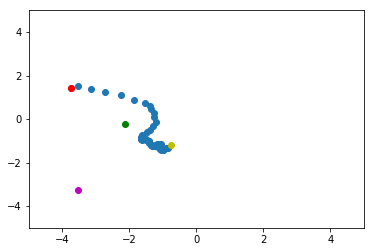

first: [1.01029085 1.03542092]
second: [-2.13919796 -0.23145501]
[[-3.54529727 -3.25900611]
 [-3.54529727 -3.25900611]]


In [247]:
nb = 9
print("target ", targets[:, :, nb])
print("first", goal_types[0, :, nb])
print("second", goal_types[1, :, nb])
plot_trajectory(array_states[:, 0,0:2,nb], goal_locations[1, :, nb], v[0, :, nb])
print("first:", goal_locations[0, :, nb])
print("second:", goal_locations[1, :, nb])
print(v[:, :, nb])

In [233]:
np.where((goal_types[0, 0, :] == 1) & (goal_types[1, 0, :] == 1))

(array([ 4, 24, 35, 36, 37, 39, 52, 57, 60, 83, 87, 90]),)

In [234]:
np.where((goal_types[0, 1, :] == 1) & (goal_types[1, 1, :] == 1))

(array([ 2, 11, 14, 15, 20, 22, 26, 41, 43, 48, 64, 76, 80, 81, 84]),)

In [36]:
vv = np.mean(goal_locations, axis = 0)

In [37]:
v = np.tile(vv, (2, 1, 1))

In [274]:
goal_types[:, :, 10]

array([[1., 0., 0.],
       [0., 1., 0.]])

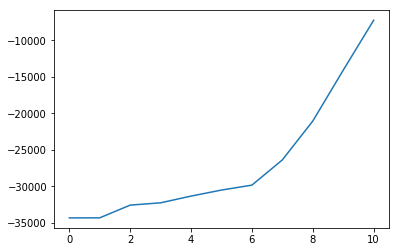

In [380]:
plt.plot(exp.reward_history[:])
plt.show()

In [47]:
exp.voc_reward_history[:]

52

In [92]:
exp.reward_history[:]

[-39983.426,
 -33963.195,
 -33019.72,
 -32202.385,
 -31566.133,
 -30672.186,
 -29445.53,
 -27835.027,
 -25698.828,
 -22637.34,
 -18704.424,
 -14985.434,
 -10585.431,
 -7404.117,
 nan]

In [159]:
def dirichlet_log_lik_end(utterances_array):
    #Note: we don't take minus the log-likelihood as we minimize minus the entire reward then !
    tr = tf.argmax(utterances_array, axis = 2)
    oh = tf.one_hot(tr, depth = FLAGS.vocabulary_size)
    idx = tf.where(tf.equal(oh, 1))
    new_utt = tf.transpose(utterances_array, [0, 1, 3, 2])
    f = tf.gather_nd(new_utt, idx)
    return f, idx, oh, new_utt

In [160]:
utt = tf.Variable(array_utterances[1:, :, :, :])
init = tf.global_variables_initializer()

In [161]:
with tf.Session() as sess:
    sess.run(init)
    f, idx, oh, new_utt  = sess.run(dirichlet_log_lik_end(utt))

In [170]:
new_utt[9, 1, 30, :] == array_utterances[10, 1, :, 30]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [382]:
array_utterances[1, 0, :, 0]


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)

In [173]:
np.sum(np.log(f))

-8858.54

In [249]:
np.argmax(array_utterances, axis = 2)[:, 0, 9]

array([0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8])

In [250]:
np.argmax(array_utterances, axis = 2)[:, 1, 9]

array([0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8])

In [296]:
array_states.shape

(51, 5, 9, 100)

In [40]:
array_utterances[:, 0, :, 0]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [89]:
exp.mean_act_count[-2]

3.34

In [383]:
a

In [384]:
w

[array([[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],
 
        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32),
 array([[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],
 
        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan,

In [14]:
array_utterances.shape

(51, 2, 20, 100)

In [44]:
np.unique(np.argmax(array_utterances, axis = 2))

array([0])

In [33]:
array_mem_last

array([[[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [ 0.        ,  0.        

In [37]:
print_stat_vocabulary(array_utterances[1:, :, :,:], 50)

1.0

In [40]:
np.argmax(array_utterances[1:, :, :,:], axis = 2)

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])

In [55]:
exp.grads_history[-2]

[(array([[[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32),
  array([[[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)),
 (array([[[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32),
  array([[[nan, nan, nan, ..., nan, nan, nan],
       

In [80]:
exp.reward_history[-2]

-7404.117

In [79]:
exp.voc_reward_history[-2]

-2982.8118

In [82]:
exp.grads_history[-3]

[(array([[[ 1.47673445e-05,  1.54627446e-06,  1.24575456e-06, ...,
           -2.21708933e-06, -2.24523296e-06, -7.42790235e-07],
          [ 8.30649060e-06,  3.17411991e-06,  8.89529531e-07, ...,
           -1.73652757e-06, -1.93111691e-06, -6.99850659e-07],
          [-3.22380697e-06,  1.78292271e-06, -3.66939474e-07, ...,
            1.02273759e-06,  9.62137392e-07,  5.18525951e-07],
          ...,
          [ 7.92474475e-06,  6.42736040e-07,  7.18263664e-07, ...,
           -1.27962994e-06, -1.49067114e-06, -4.83573274e-07],
          [-4.63911789e-07, -9.43565681e-07, -3.17240733e-07, ...,
            9.36355377e-07,  9.63759362e-07,  5.77166418e-07],
          [-2.25334293e-06,  2.40926011e-06, -8.41664090e-08, ...,
            2.64068916e-07,  2.09471580e-07,  8.10523559e-08]]],
        dtype=float32),
  array([[[-0.03720136,  0.02738267, -0.10492499, ...,  0.03265355,
           -0.01473366,  0.03938138],
          [-0.1201808 , -0.04262943, -0.04833237, ...,  0.00788608,
     

In [91]:
exp.vars_history[-2]

[array([[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32),
 array([[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32),
 array([[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32),
 array([[[nan],
         [nan],
         [nan],
         [nan],
         [na